In [1]:
import matplotlib.pyplot as plt
import itertools
import math
import numpy as np
import pickle

def plot_bo_avg_across_results(data,
                    fixed_params=None,
                    plot_metric='best_vals_avg',
                    show_legend=True,
                    max_colors=10,
                    avg_across=None,
                    std_band=False):
    import matplotlib.pyplot as plt
    import itertools
    import math
    import numpy as np

    fixed_params = fixed_params or {}
    avg_across = avg_across or {}

    assert len(avg_across) <= 1, "avg_across must be one key only"

    avg_key = None
    avg_vals = []
    if avg_across:
        avg_key, avg_vals = list(avg_across.items())[0]

    fixed_param_lists = {
        k: v if isinstance(v, list) else [v]
        for k, v in fixed_params.items()
    }

    fixed_param_combos = list(itertools.product(*fixed_param_lists.values())) or [()]
    fixed_param_keys = list(fixed_param_lists.keys())

    num_plots = len(fixed_param_combos)
    ncols = min(3, num_plots)
    nrows = math.ceil(num_plots / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols + 2, 4 * nrows), squeeze=False)
    axs = axs.flatten()
    base_colors = plt.cm.get_cmap('tab10').colors
    line_styles = ['-', '--', ':', '-.']
    all_handles_labels = []

    for plot_idx, combo in enumerate(fixed_param_combos):
        combo_params = dict(zip(fixed_param_keys, combo))
        ax = axs[plot_idx]

        for idx, v in enumerate(avg_vals):
            # Build list of data segments to average
            collected = []
            matching_params = combo_params.copy()
            matching_params[avg_key] = v

            fn_list = [matching_params['function_name']] if 'function_name' in matching_params else list(data.keys())
            for fn in fn_list:
                if fn not in data:
                    continue
                fn_data = data[fn]
                second_keys = list(fn_data.keys())
                example = fn_data[second_keys[0]]
                is_gp = isinstance(example, dict) and all(isinstance(k, str) and not k.startswith('q') for k in example)

                if is_gp:
                    for gp in fn_data:
                        if 'gp_model' in matching_params and gp != matching_params['gp_model']:
                            continue
                        for opt in fn_data[gp]:
                            if 'optim_method' in matching_params and opt != matching_params['optim_method']:
                                continue
                            for qk in fn_data[gp][opt]:
                                qval_strat = qk[1:].split('_')
                                if len(qval_strat) != 2:
                                    continue
                                qval, strat = qval_strat
                                if 'q' in matching_params and int(qval) != matching_params['q']:
                                    continue
                                if 'sampling_strategy' in matching_params and strat != matching_params['sampling_strategy']:
                                    continue
                                y = fn_data[gp][opt][qk].get(plot_metric)
                                if y is not None:
                                    collected.append(y[:, 0] if y.ndim == 2 else y)
                else:
                    for dr in fn_data:
                        if 'dim_red' in matching_params and dr != matching_params['dim_red']:
                            continue
                        for nc in fn_data[dr]:
                            if 'n_components' in matching_params and nc != matching_params['n_components']:
                                continue
                            for qk in fn_data[dr][nc]:
                                qval_strat = qk[1:].split('_')
                                if len(qval_strat) != 2:
                                    continue
                                qval, strat = qval_strat
                                if 'q' in matching_params and int(qval) != matching_params['q']:
                                    continue
                                if 'sampling_strategy' in matching_params and strat != matching_params['sampling_strategy']:
                                    continue
                                y = fn_data[dr][nc][qk].get(plot_metric)
                                if y is not None:
                                    collected.append(y[:, 0] if y.ndim == 2 else y)

            if not collected:
                continue

            min_len = min(len(y) for y in collected)
            y_avg = np.mean([y[:min_len] for y in collected], axis=0)
            x = range(1, min_len + 1)

            color = base_colors[idx % max_colors]
            linestyle = line_styles[idx // max_colors % len(line_styles)]
            label = f"{avg_key}={v}"
            line, = ax.plot(x, y_avg, label=label, color=color, linestyle=linestyle)

            if std_band:
                y_stack = np.array([y[:min_len] for y in collected])
                y_std = np.std(y_stack, axis=0)
                ax.fill_between(x, y_avg - y_std, y_avg + y_std, color=color, alpha=0.2)

            all_handles_labels.append((label, line))

        # Improved title logic
        if avg_across and fixed_params:
            fixed_desc = " | ".join(f"{k}={v}" for k, v in combo_params.items())
            title_str = f"Average {plot_metric} over {avg_key} values\nGiven {fixed_desc}"
        elif avg_across:
            title_str = f"Average {plot_metric} over {avg_key} values"
        elif fixed_params:
            title_str = " | ".join(f"{k}={v}" for k, v in combo_params.items())
        else:
            title_str = plot_metric

        ax.set_title(title_str, pad=12)
        ylabel_map = {
            'best_vals_avg': 'Average Best Value',
            'mae_vals_avg': 'Average MAE (Prediction Vs. Truth)',
            'recon_mae_avg': 'Average MAE (Reconstruction)',
        }
        ax.set_ylabel(ylabel_map.get(plot_metric, plot_metric))
        ax.set_xlabel("BO Iteration")

    if show_legend:
        seen = {}
        for label, handle in all_handles_labels:
            if label not in seen:
                seen[label] = handle
        fig.legend(seen.values(), seen.keys(), fontsize='small',
                   loc='center left', bbox_to_anchor=(1.01, 0.5))

    plt.tight_layout(rect=[0.03, 0, 0.97, 0.95])
    plt.show()

def plot_bo_standard_results(data,
                    fixed_params=None,
                    plot_metric='best_vals_avg',
                    show_legend=True,
                    max_colors=10):
    fixed_params = fixed_params or {}

    fixed_param_lists = {
        k: v if isinstance(v, list) else [v]
        for k, v in fixed_params.items()
    }

    fixed_param_combos = list(itertools.product(*fixed_param_lists.values()))
    fixed_param_keys = list(fixed_param_lists.keys())
    num_plots = len(fixed_param_combos)

    use_subplots = num_plots > 1
    ncols = min(3, num_plots)
    nrows = math.ceil(num_plots / ncols)

    fig_width = 5 * ncols + 2
    fig_height = 4 * nrows
    fig, axs = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)
    axs = np.array(axs).reshape(nrows, ncols)

    base_colors = plt.cm.get_cmap('tab10').colors
    line_styles = ['-', '--', ':', '-.']

    all_handles_labels = []

    for i, combo in enumerate(fixed_param_combos):
        combo_params = dict(zip(fixed_param_keys, combo))

        fn = combo_params['function_name']
        fn_data = data[fn]
        second_level_keys = list(fn_data.keys())
        example_second = fn_data[second_level_keys[0]]
        is_gp_based = isinstance(example_second, dict) and all(
            isinstance(k, str) and not k.startswith("q") for k in example_second.keys()
        )

        if is_gp_based:
            gp_models, optim_methods, q_keys = set(), set(), set()
            for gp in fn_data:
                gp_models.add(gp)
                for opt in fn_data[gp]:
                    optim_methods.add(opt)
                    q_keys.update(fn_data[gp][opt].keys())
            vary_keys = [('gp_model', sorted(gp_models)),
                         ('optim_method', sorted(optim_methods))]
        else:
            dim_reds, n_components_list, q_keys = set(), set(), set()
            for dr in fn_data:
                dim_reds.add(dr)
                for nc in fn_data[dr]:
                    n_components_list.add(nc)
                    q_keys.update(fn_data[dr][nc].keys())
            vary_keys = [
                ('dim_red', sorted(dim_reds, key=str)),
                ('n_components', sorted(n_components_list, key=lambda x: int(x) if x is not None else -1))
            ]

        q_strat_pairs = []
        for qk in q_keys:
            if isinstance(qk, str) and qk.startswith("q"):
                rest = qk[1:]
                if "_" in rest:
                    q_val, strat = rest.split("_", 1)
                elif "None" in rest:
                    q_val, strat = rest, "None"  # fallback for cases like q1_None
                try:
                    q_strat_pairs.append((int(q_val), strat))
                except ValueError:
                    continue

        q_list = sorted(set(q for q, _ in q_strat_pairs))
        sampling_strategies = sorted(set(s for _, s in q_strat_pairs))
        vary_keys += [('q', q_list), ('sampling_strategy', sampling_strategies)]

        vary_dict = dict(vary_keys)
        vary_params = [p for p in vary_dict if p not in combo_params]

        ax = axs[i // ncols][i % ncols]

        all_line_param_combos = list(itertools.product(*[vary_dict[p] for p in vary_params]))
        total_lines = len(all_line_param_combos)

        for idx, subcombo in enumerate(all_line_param_combos):
            params = combo_params.copy()
            for j, p in enumerate(vary_params):
                params[p] = subcombo[j]

            q_key = f"q{params['q']}_{params['sampling_strategy']}"
            color_idx = idx % max_colors
            linestyle_idx = idx // max_colors
            color = base_colors[color_idx]
            linestyle = line_styles[linestyle_idx % len(line_styles)]

            try:
                if is_gp_based:
                    result = data[fn][params['gp_model']][params['optim_method']][q_key]
                else:
                    result = data[fn][params['dim_red']][params['n_components']][q_key]
                y = result.get(plot_metric)
                if y is None:
                    continue
                if y.ndim == 2:
                    y = y[:, 0]
                x = range(1, len(y) + 1)

                label_parts = []
                for key in ['gp_model', 'optim_method', 'dim_red', 'n_components', 'q', 'sampling_strategy']:
                    if key in params and key not in fixed_param_keys:
                        label_parts.append(f"{key}={params[key]}")
                label = ", ".join(label_parts)
                line, = ax.plot(x, y, label=label, color=color, linestyle=linestyle)
                all_handles_labels.append((label, line))
            except KeyError:
                continue

        ylabel_map = {
            'best_vals_avg': 'Average Best Value',
            'mae_vals_avg': 'Average MAE (Prediction)',
            'recon_mae_avg': 'Average MAE (Reconstruction)',
        }
        ylabel = ylabel_map.get(plot_metric, plot_metric)
        title_str = " | ".join(f"{k}={v}" for k, v in combo_params.items())
        mid = len(title_str) // 2
        split_idx = title_str.find(" | ", mid)
        if split_idx == -1:
            split_idx = title_str.rfind(" | ")
        if split_idx != -1:
            title_str = title_str[:split_idx] + "\n" + title_str[split_idx + 3:]
        ax.set_title(title_str, pad=12)

        ax.set_xlabel("BO Iteration")
        ax.set_ylabel(ylabel)

    if show_legend:
        # Keep first handle for each unique label
        seen = {}
        for label, handle in all_handles_labels:
            if label not in seen:
                seen[label] = handle
        fig.legend(seen.values(), seen.keys(), fontsize='small',
                   loc='center left', bbox_to_anchor=(1.01, 0.5))

    if use_subplots:
        big_title_map = {
            'best_vals_avg': 'Bayesian Optimization Results - Avg Best Value',
            'mae_vals_avg': 'Bayesian Optimization Results - MAE (Prediction)',
            'recon_mae_avg': 'Bayesian Optimization Results - MAE (Reconstruction)',
        }
        big_title = big_title_map.get(plot_metric, f'BO Results - {plot_metric}')
        fig.suptitle(big_title, fontsize=16)
        plt.subplots_adjust(top=0.9)

    plt.tight_layout(rect=[0.03, 0, 0.97, 0.95])
    plt.show()

def plot_bo_results(data,
                    fixed_params=None,
                    plot_metric='best_vals_avg',
                    show_legend=True,
                    max_colors=10,
                    avg_across=None,
                    std_band=False):
    if avg_across:
        return plot_bo_avg_across_results(data=data,
                    fixed_params=fixed_params,
                    plot_metric=plot_metric,
                    show_legend=show_legend,
                    max_colors=max_colors,
                    avg_across=avg_across,
                    std_band=std_band)
    else:
        return plot_bo_standard_results(data=data,
                    fixed_params=fixed_params,
                    plot_metric=plot_metric,
                    show_legend=show_legend,
                    max_colors=max_colors)

In [2]:
with open('second_attempt_first_experiment.pkl', 'rb') as f:
    experiment_1 = pickle.load(f)

with open('second_experiment.pkl', 'rb') as f:
    experiment_2 = pickle.load(f)

with open('third_experiment.pkl', 'rb') as f:
    experiment_3 = pickle.load(f)

experiment 1 plots

In [3]:
'function_name',        "RoelfesCoef", "Ackley", "AckleyMixed", "Griewank",  "RoelfesMaxYield", "RoelfesNormGrad", 
# "Labs" is also a valid function_name, but due to a mistake, we minimized the merit factor instead of maximizing.
'dim_red',              'PCA', 'Autoencoder', 'WeightedAutoencoder', 'None',
'n_components',         2, 16, 32
'q',                    1, 2, 4, 16
'sampling_strategy'     'None', 'Monte Carlo', 'Sequential'
# 'None' Only appears for q=1 and it means that an Analytic acquisition function was chosen.
# Although not explicitly stated, the optimization method used was Multi-Start optimization implemented by BoTorch.

'plot_metric',          'best_vals_avg', 'mae_vals_avg', 'recon_mae_avg'

('plot_metric', 'best_vals_avg', 'mae_vals_avg', 'recon_mae_avg')

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


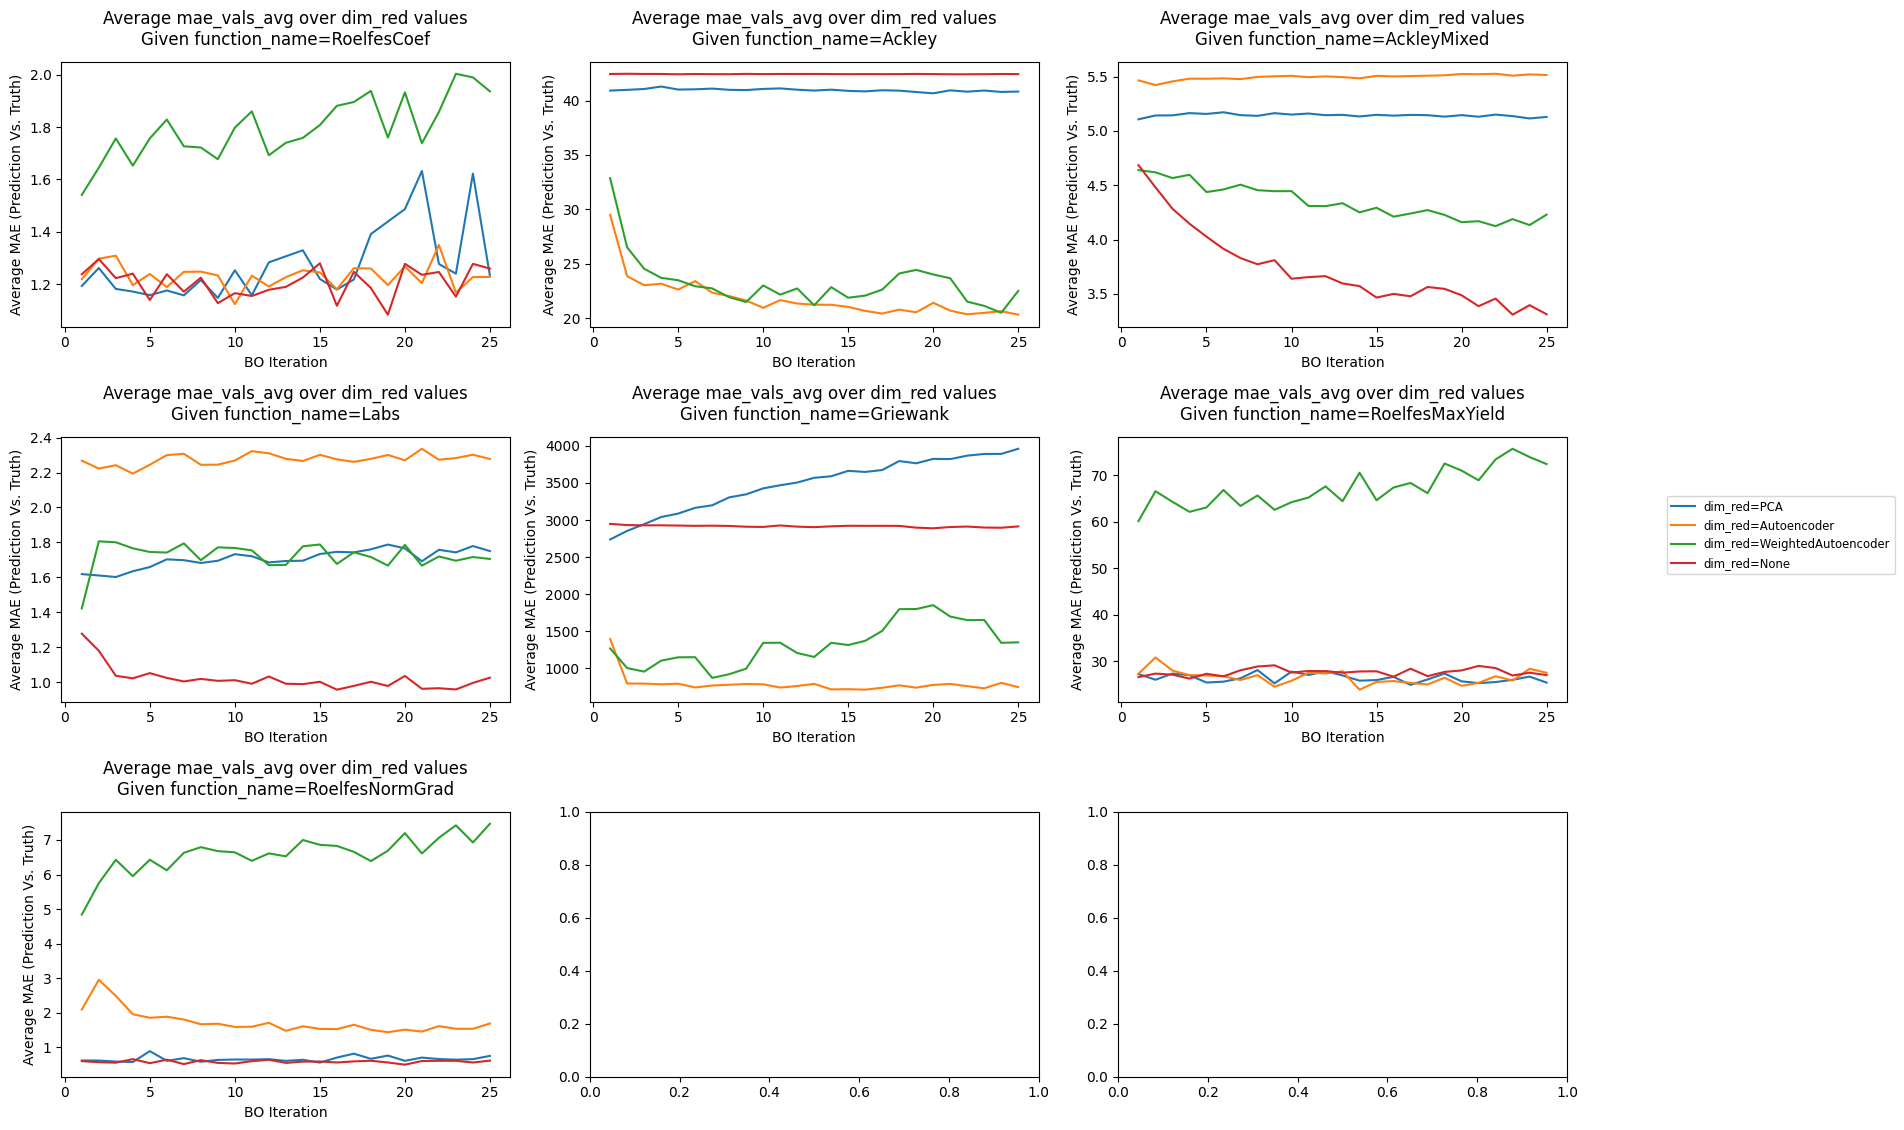

In [18]:
plot_bo_results(experiment_1, plot_metric='mae_vals_avg', avg_across={'dim_red': ['PCA', 'Autoencoder', 'WeightedAutoencoder', 'None']},
                fixed_params={'function_name':["RoelfesCoef", "Ackley", "AckleyMixed", "Labs", "Griewank",  "RoelfesMaxYield", "RoelfesNormGrad",]})

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


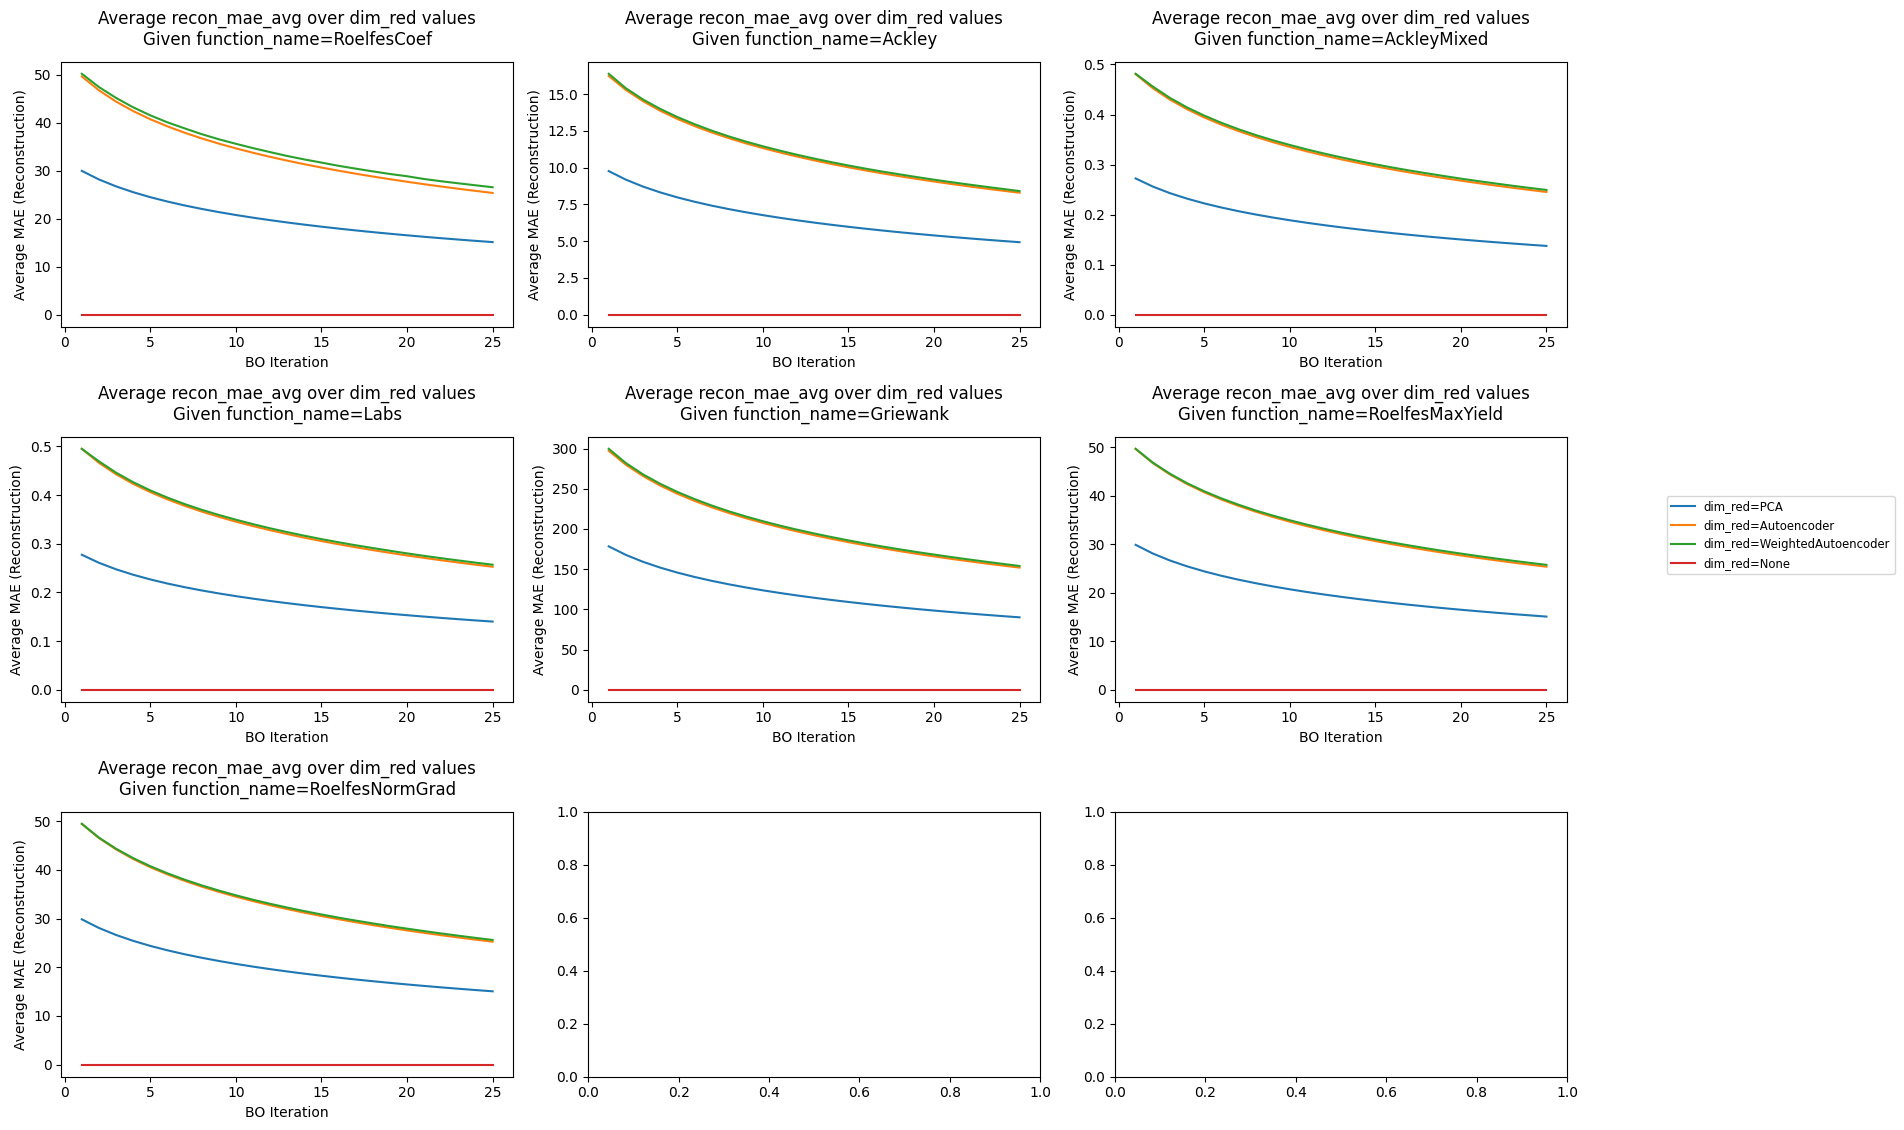

In [6]:
plot_bo_results(experiment_1, plot_metric='recon_mae_avg', avg_across={'dim_red': ['PCA', 'Autoencoder', 'WeightedAutoencoder', 'None']},
                fixed_params={'function_name':["RoelfesCoef", "Ackley", "AckleyMixed", "Labs", "Griewank",  "RoelfesMaxYield", "RoelfesNormGrad",]})

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


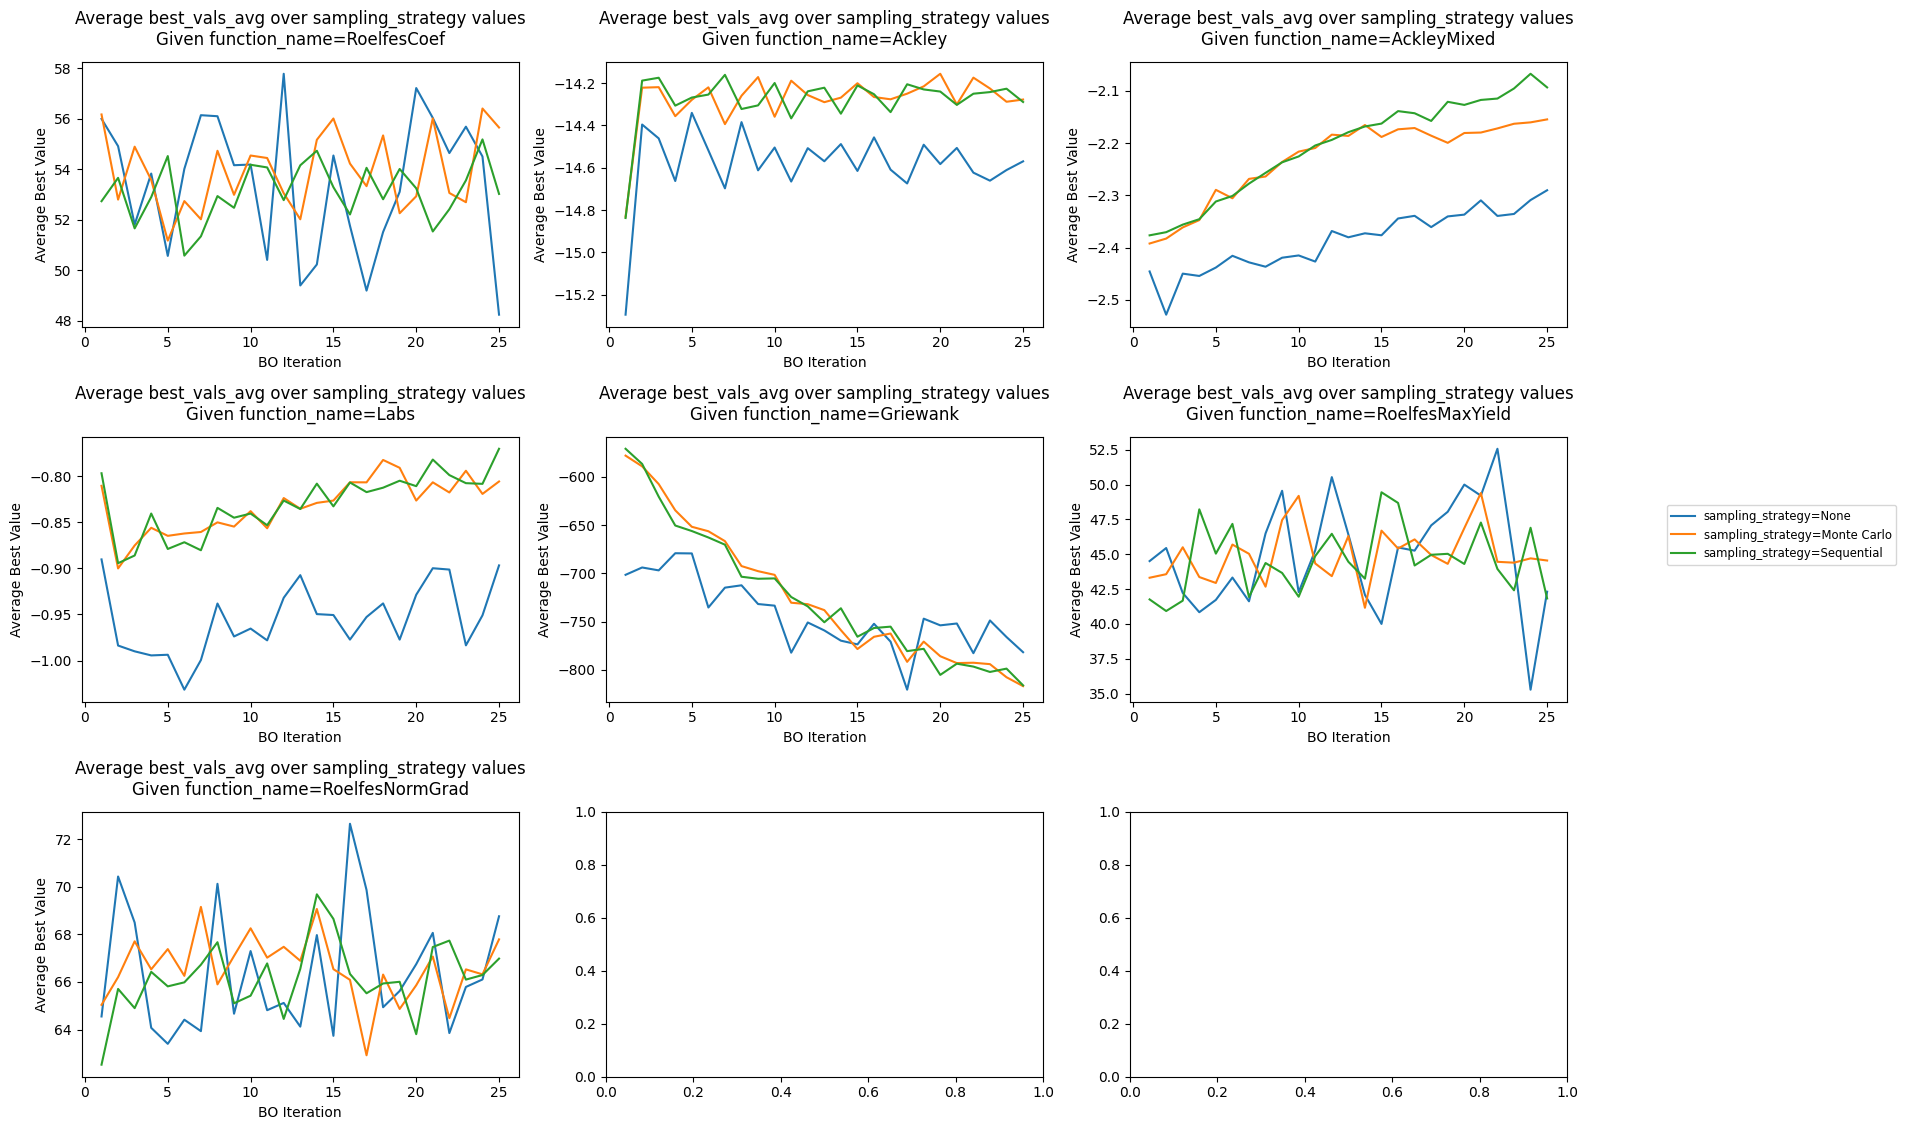

In [7]:
plot_bo_results(experiment_1, avg_across={'sampling_strategy': ['None', 'Monte Carlo', 'Sequential']}, 
                fixed_params={"function_name": ["RoelfesCoef", "Ackley", "AckleyMixed", "Labs", "Griewank",  "RoelfesMaxYield", "RoelfesNormGrad",]})

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


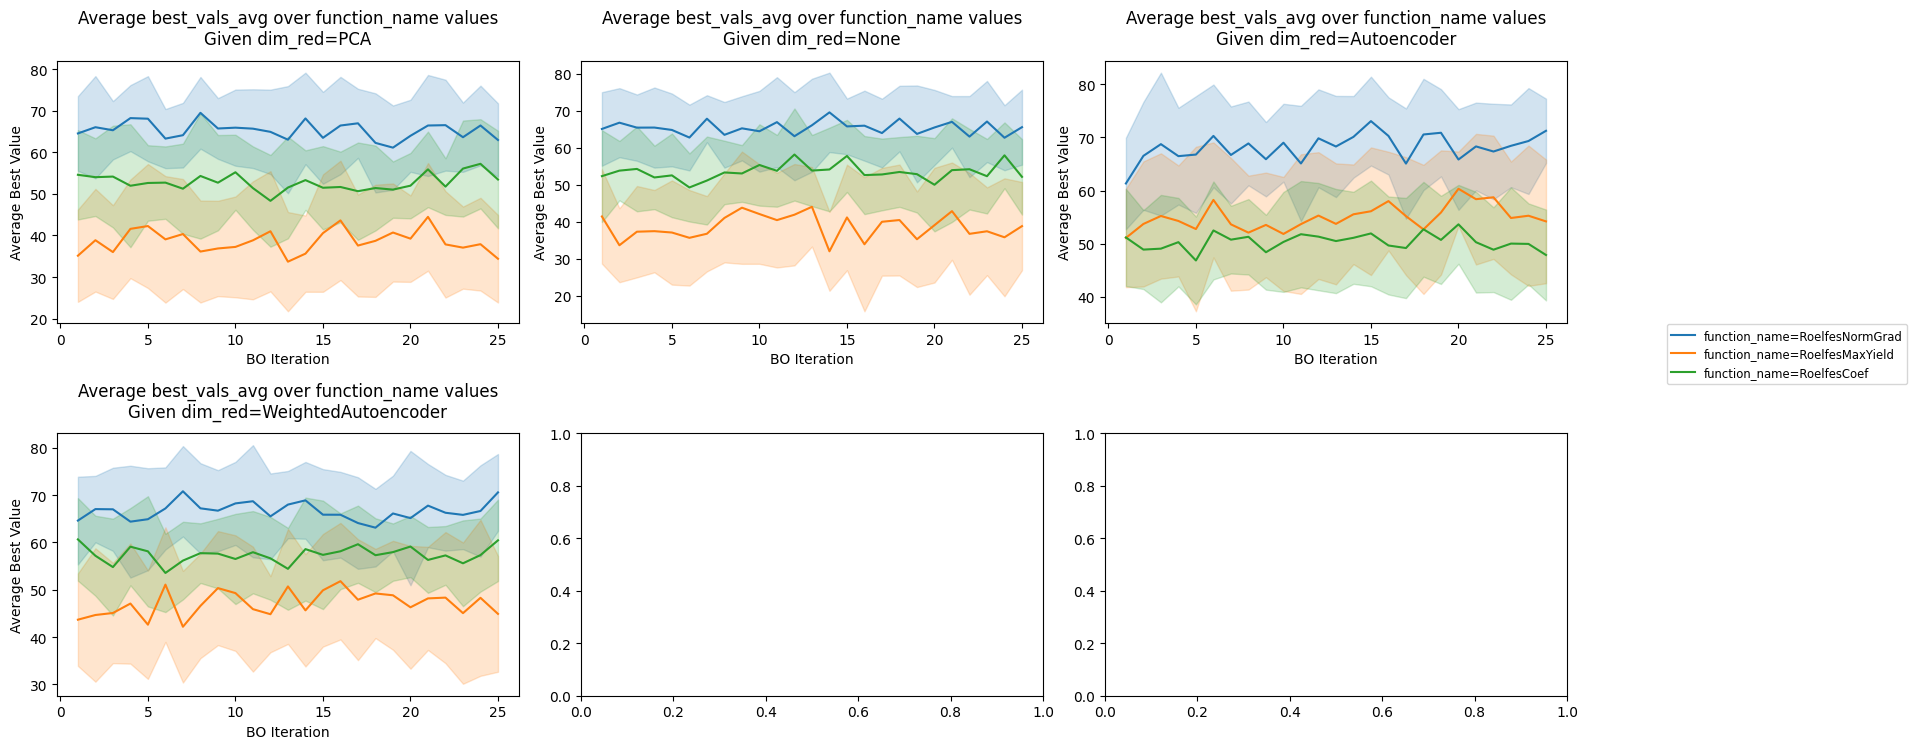

In [8]:
plot_bo_results(experiment_1, std_band=True, avg_across={"function_name": ["RoelfesNormGrad", "RoelfesMaxYield", "RoelfesCoef"]}, 
                fixed_params={'dim_red':["PCA","None", "Autoencoder", "WeightedAutoencoder"]})

Experiment 2

In [9]:
'function_name',        "AckleyMixed", 
# "Labs" is also a valid function_name, but due to a mistake, we minimized the merit factor instead of maximizing.

'optim_method',         'Multi-Start',
'gp_model',             'HED', 'Mixed Single-Task GP', 'Single-Task GP'
# Single-Task GP is applied with one-hot encoding, although that is not necessary for Labs or AckleyMixed, since they are binary.
'q',                    1, 2, 4, 16
'sampling_strategy'     'None', 'Monte Carlo', 'Sequential'
# 'None' Only appears for q=1 and it means that an Analytic acquisition function was chosen.

'plot_metric',          'best_vals_avg', 'mae_vals_avg',

('plot_metric', 'best_vals_avg', 'mae_vals_avg')

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


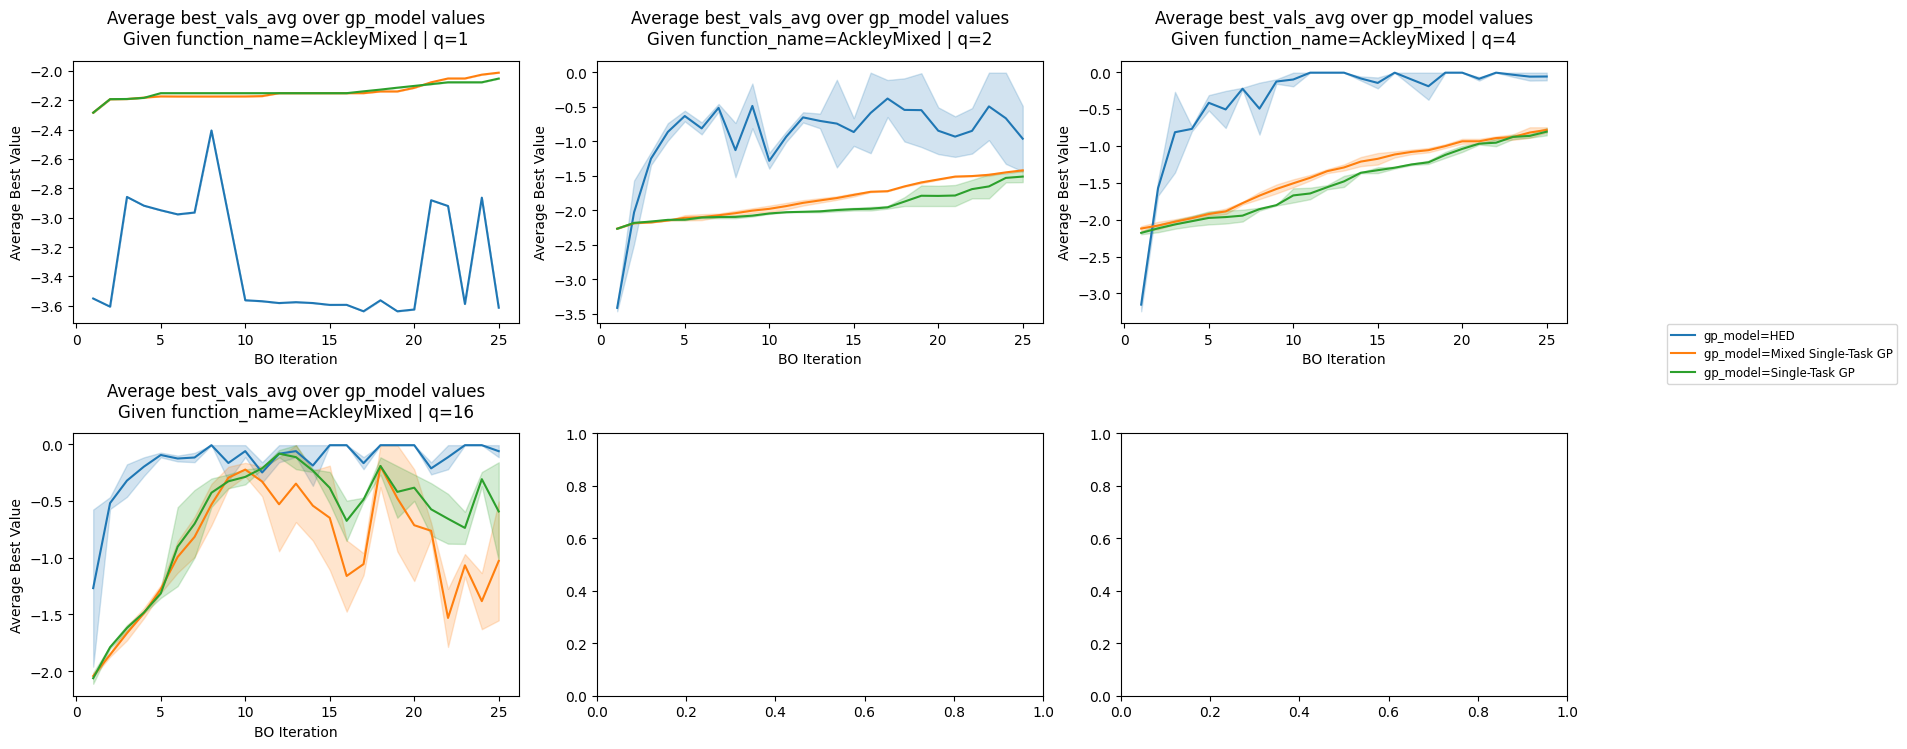

In [10]:
plot_bo_results(experiment_2, avg_across={'gp_model':['HED', 'Mixed Single-Task GP', 'Single-Task GP']}, 
                fixed_params={'function_name':['AckleyMixed'],'q':[1, 2, 4, 16]}, std_band=True)

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


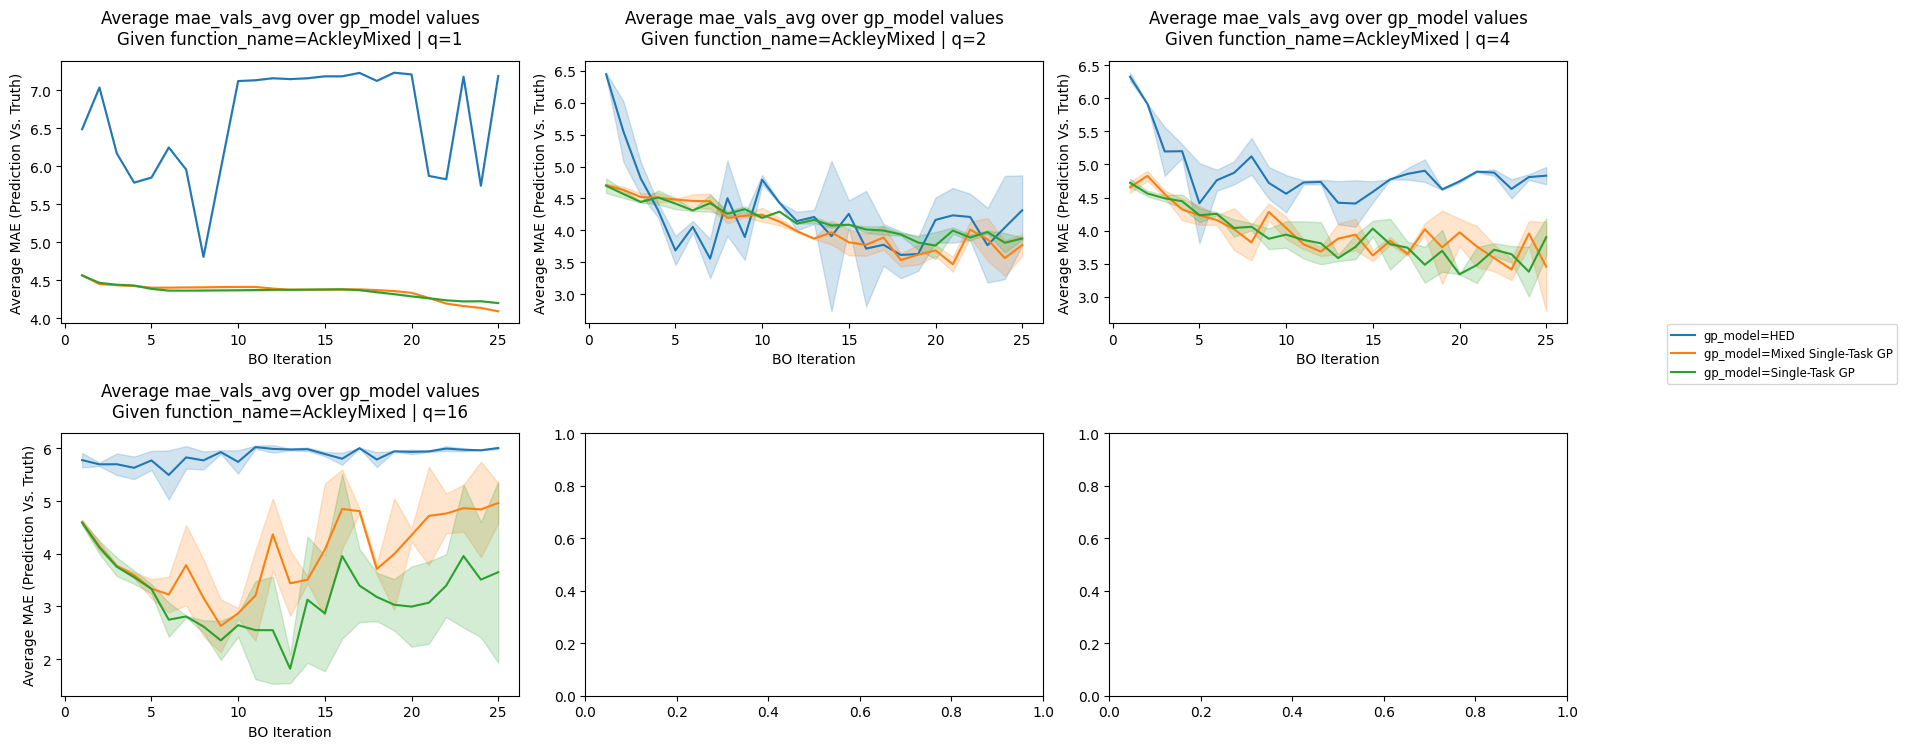

In [11]:
plot_bo_results(experiment_2, plot_metric='mae_vals_avg', avg_across={'gp_model':['HED', 'Mixed Single-Task GP', 'Single-Task GP']}, 
                fixed_params={'function_name':['AckleyMixed'],'q':[1, 2, 4, 16]}, std_band=True)

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


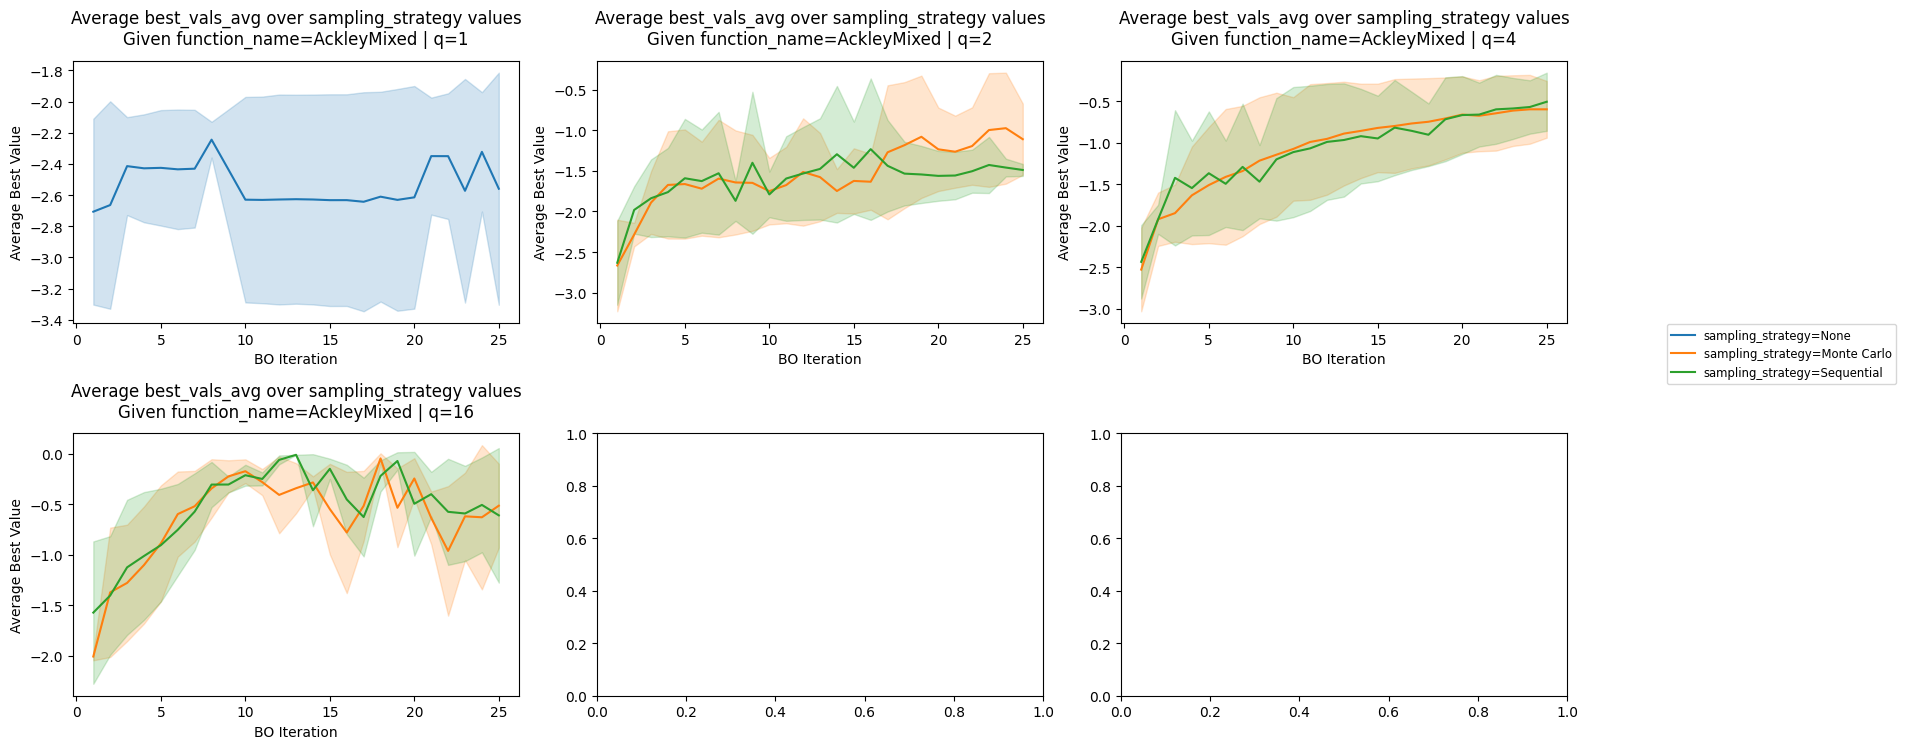

In [12]:
plot_bo_results(experiment_2, avg_across={'sampling_strategy':['None', 'Monte Carlo', 'Sequential']}, 
                fixed_params={'function_name':['AckleyMixed'],'q':[1, 2, 4, 16], }, std_band=True)

Experiment  3

In [13]:
'function_name',        "AckleyMixed", 
# "Labs" is also a valid function_name, but due to a mistake, we minimized the merit factor instead of maximizing.
'optim_method',         'Sequential Greedy',
# A more appropiate name for this optimization method would be Relaxed subspace optimization.
# for m amount of times: we choose to fix n variables and optimize over the induced subspace to retrieve k batches of candidates. 
# We return 1 candidate by maximizing over the m * k batches of candidates.
# We repeat this q amount of times to retrieve q candidates.
# We chose m = 8 to save on computation time. 
# We chose n = dim(Z) - round(dim(Z) / 2), where dim(Z) is the dimensionality of the categorical subspace (amount of categorical features).
# We chose k = 20 (raw_samples).
'gp_model',             'HED', 'Mixed Single-Task GP', 'Single-Task GP'
# Single-Task GP is applied with one-hot encoding, although that is not necessary for Labs or AckleyMixed, since they are binary.
'q',                    1, 2, 4, 16
'sampling strategy',    'Monte Carlo',
#In reality, Monte Carlo is not used, but only MC based acquisition functions are compatible with the BoTorch optimize_mixed_acqf function.

'plot_metric',          'best_vals_avg', 'mae_vals_avg',

('plot_metric', 'best_vals_avg', 'mae_vals_avg')

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


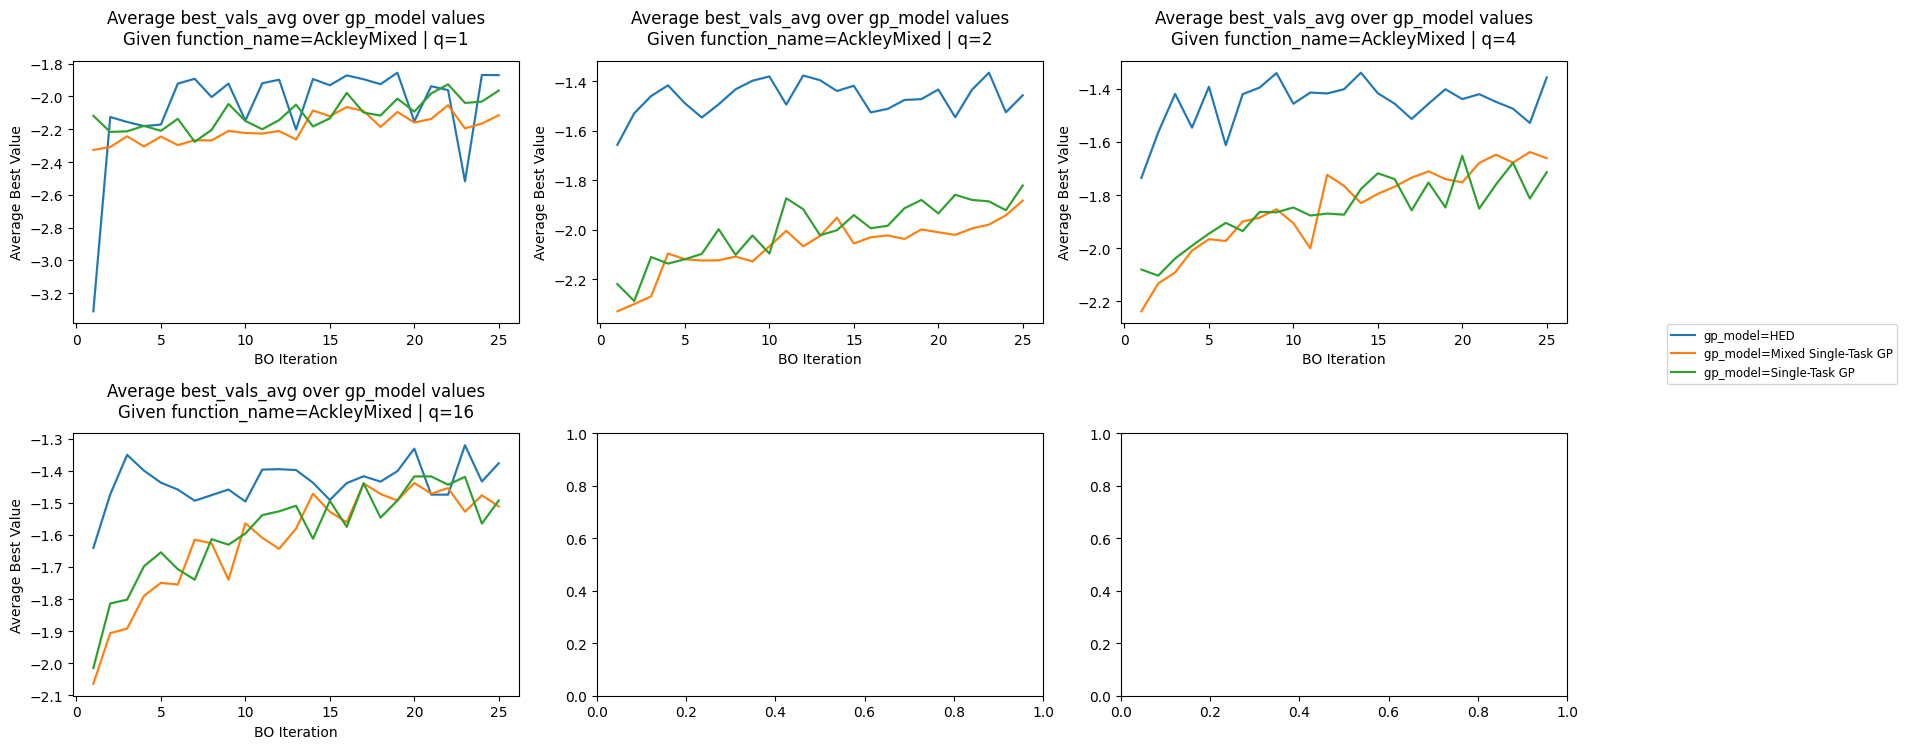

In [14]:
#We use avg_across, but that is only for consistent coloring.
plot_bo_results(experiment_3, avg_across={'gp_model':['HED', 'Mixed Single-Task GP', 'Single-Task GP']},
                fixed_params={'function_name':['AckleyMixed'],'q':[1, 2, 4, 16],}, std_band=True)

C:\Users\danin\AppData\Local\Temp\ipykernel_19524\3256747393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10').colors


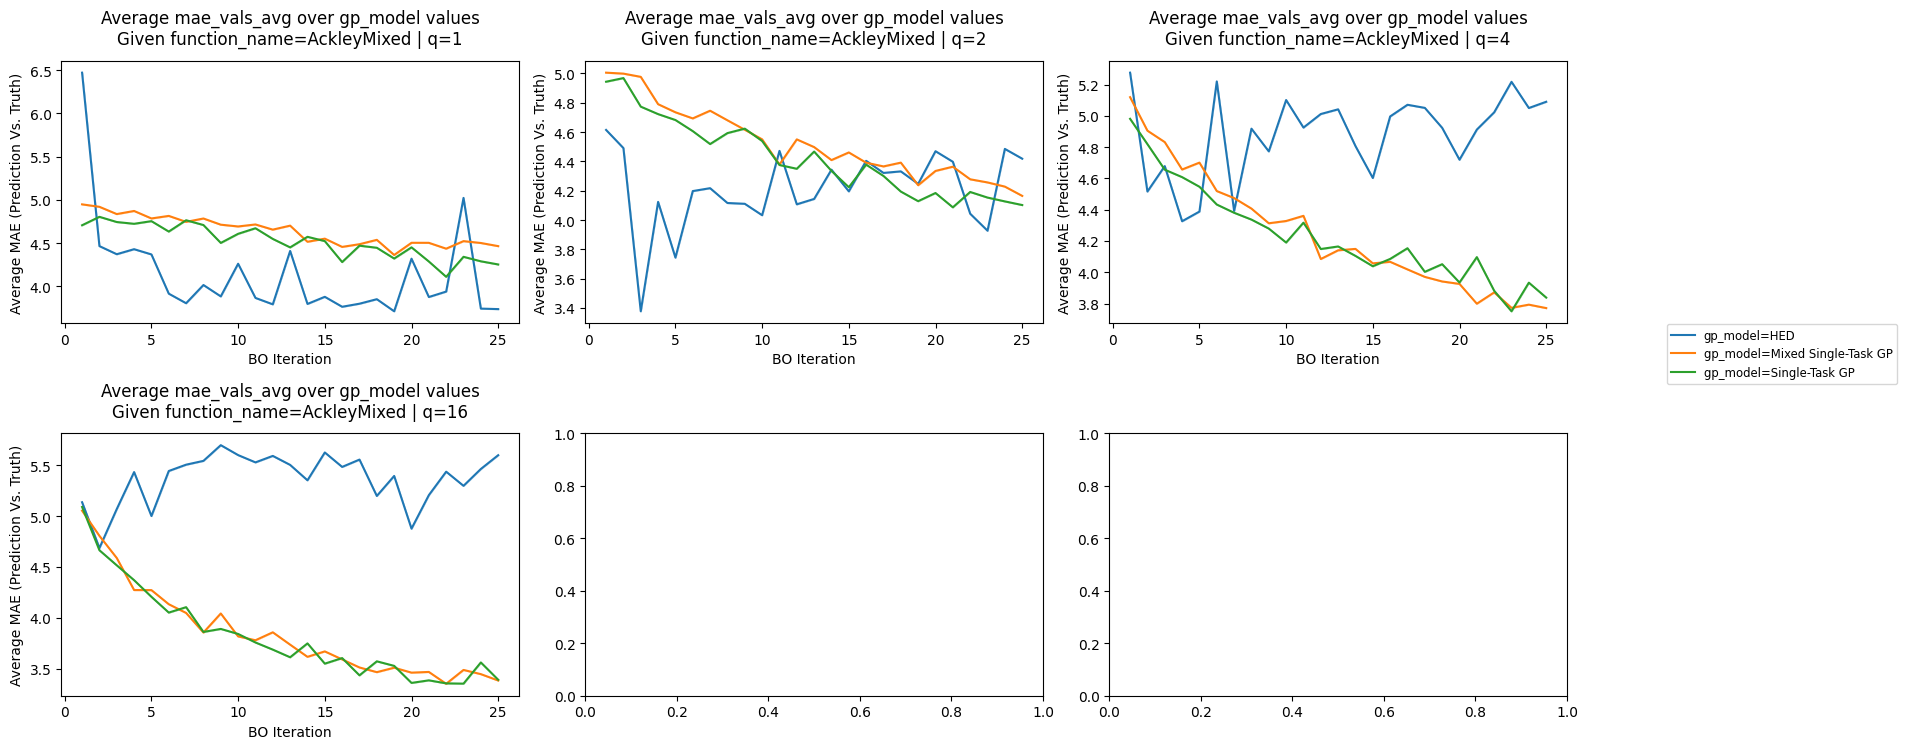

In [15]:
plot_bo_results(experiment_3, plot_metric='mae_vals_avg', avg_across={'gp_model':['HED', 'Mixed Single-Task GP', 'Single-Task GP']}, 
                fixed_params={'function_name':['AckleyMixed'],'q':[1, 2, 4, 16]}, std_band=True)

Wish we had 1 plot combining all three experiments for the best_valss at least.